In [1]:
import numpy as np

import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from xhistogram.xarray import histogram
import dask.dataframe as dd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import mitequinox.utils as ut
from mitequinox.plot import *
import mitequinox.parcels as pa
from xmitgcm import llcreader

from fsspec.implementations.local import LocalFileSystem

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.5447197.datarmor0/parcels-502090/libparcels_random_52fc53ac-8ff2-4046-9e69-959b38cac08a.so


In [2]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster() #processes=7, cores=7
w = cluster.scale(jobs=4)
#
client = Client(cluster)




In [3]:
client

Client Scheduler: tcp://10.148.0.220:50827 Dashboard: http://10.148.0.220:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [4]:
def read_Ediag(V,diags):
    ds = xr.merge([ut.load_diagnostic(d+"_"+v).rename({v:d+"_"+v}) 
               for v in V for d in diags])

    grid = xr.open_zarr('/home1/datawork/xyu/grid/mit_grid.zarr')
    ds = xr.merge([ds,grid])
    #ds = ds#.isel(i = slice(0,None,4), j = slice(0,None,4), i_g = slice(0,None,4), j_g = slice(0,None,4))
    ds['lon'] = 0*ds.face+ds.XC
    ds['lat'] = 0*ds.face+ds.YC
    ds = ds.compute()
    # Rotation velocity field
    for diag in diags:
        ds['zonal_velocity_'+diag] =  ds[diag+'_SSU'].rename({'i_g': 'i'})*ds.CS - ds[diag+'_SSV'].rename({'j_g': 'j'})*ds.SN
        ds['meridional_velocity_'+diag] =  ds[diag+'_SSU'].rename({'i_g': 'i'})*ds.SN + ds[diag+'_SSV'].rename({'j_g': 'j'})*ds.CS

        ds['lon'] = 0*ds.face+ds.XC
        ds['lat'] = 0*ds.face+ds.YC
 #   ds = llcreader.faces_dataset_to_latlon(ds)
    return ds

In [15]:
def localize_Eulerian(bbox,ds,col):
    ds_sub = ds[col].where(np.logical_and(ds.lat<=bbox[3],ds.lat>=bbox[2]),drop=True).persist()
    ds_lon = ds['lon'].where(np.logical_and(ds.lat<=bbox[3],ds.lat>=bbox[2]),drop=True).persist()
    ds_lat = ds['lat'].where(np.logical_and(ds.lat<=bbox[3],ds.lat>=bbox[2]),drop=True).persist()
    ds_bis = xr.Dataset({'lon':ds_lon,'zonal_velocity_mean':ds_sub,'lat':ds_lat})
    ds_sub = ds_bis.where(np.logical_and(ds_bis.lon<=bbox[1],ds_bis.lon>=bbox[0]),drop=True).persist()
    lon_E = ds_sub.lon[0,:,0]
    lat_E = ds_sub.lat[0,0,:]
    ds_E = xr.DataArray(ds_sub.isel(face=0)['zonal_velocity_mean'].values,dims=['lon','lat'],coords={'lon':lon_E.values,'lat':lat_E.values})
    return ds_E

In [7]:
def localize_Lagrangian(bbox,df):
    df_sub = df[np.logical_and(df.lat<bbox[3],df.lat>bbox[2]
                                               )].persist()

    df_sub = df[np.logical_and(df.lon<bbox[1],df.lon>bbox[0]
                                          )].persist()
    return df_sub

In [8]:
def binned_site(bbox,df,dl,V):
    df_sub = df[np.logical_and(df.lat<bbox[3],df.lat>bbox[2]
                                               )].persist()

    df_sub = df[np.logical_and(df.lon<bbox[1],df.lon>bbox[0]
                                          )].persist()
    lon = np.arange(bbox[0],bbox[1], dl)
    lat = np.arange(bbox[-2], bbox[-1], dl)
    df_sub['lon'] = (df_sub['lon']+180)%360 - 180
    df_sub['lon_cut'] = df_sub['lon'].map_partitions(pd.cut, lon)
    df_sub['lat_cut'] = df_sub['lat'].map_partitions(pd.cut, lat)
    df_sub = df_sub.persist()
    uv_sub = df_sub.groupby(['lon_cut','lat_cut']).mean().compute()
    return uv_sub

In [38]:
# Lagrangian data
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'

p = pa.parcels_output(root_dir+run_name, parquets=['time_mean'])
df = p.df['time_mean']

df = pa.degs2ms(df) #Convert in m/s 

df = df.persist()

In [40]:
df = df.drop(columns=['temperature','sea_level','salinity','SST_interp','SSS_interp','Eta_interp'])
df = df.rename(columns={'SSU_interp':'zonal_velocity_mean','SSV_interp':'meridional_velocity_mean'})

In [41]:
df= df.persist()

In [5]:
# Eulerian data
V = ["SSU","SSV"]#["SSU", "SSV"]
D = ["mean"]#, "prime_mean","prime_mean_sq"]
ds = read_Ediag(V,D)

In [9]:
bbox = [-128, -123, 33, 38] # small bbox
dl = 1.

In [53]:
df_sub = localize_Lagrangian(bbox,df)

In [56]:
df_sub = df_sub.compute()

In [10]:
ds_sub = localize_Eulerian(bbox,ds,'zonal_velocity_mean')

In [16]:
ds_sub_V = localize_Eulerian(bbox,ds,'meridional_velocity_mean')

In [27]:
ds_sub.name = 'zonal_velocity_mean'
ds_sub_V.name = 'meridional_velocity_mean'

In [28]:
_ds_sub = xr.merge([ds_sub,ds_sub_V])

In [34]:
_ds_sub

<xarray.Dataset>
Dimensions:                   (lat: 320, lon: 240)
Coordinates:
  * lon                       (lon) float64 -128.0 -128.0 ... -123.0 -123.0
  * lat                       (lat) float64 37.99 37.98 37.96 ... 33.02 33.01
Data variables:
    zonal_velocity_mean       (lon, lat) float32 -0.0007393 0.001687 ... 0.03561
    meridional_velocity_mean  (lon, lat) float32 -0.08 -0.07922 ... -0.09239

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


<AxesSubplot:xlabel='lon', ylabel='lat'>

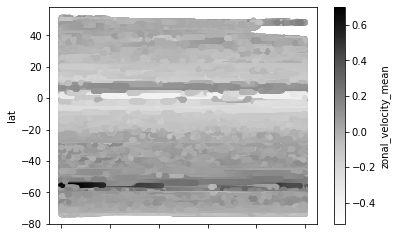

In [57]:
df_sub.plot.scatter(x='lon',y='lat',c='zonal_velocity_mean')

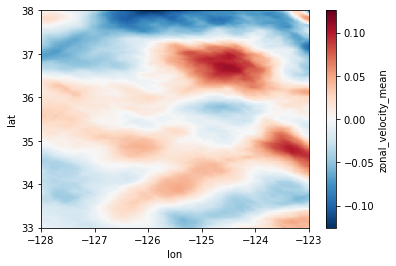

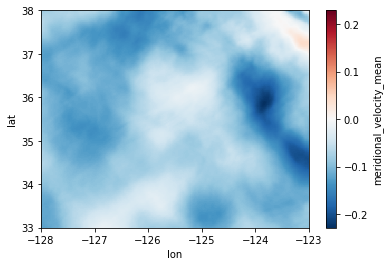

In [37]:
_ds_sub['zonal_velocity_mean'].plot(y='lat')
plt.figure()
_ds_sub['meridional_velocity_mean'].plot(y='lat')

In [ ]:
cluster.close()